# TM10007 Assignment

In [61]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Load and analyse data

The number of samples: 246
The number of columns: 494
The number of features that are not normally distributed: 443


c:\Users\lisan\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


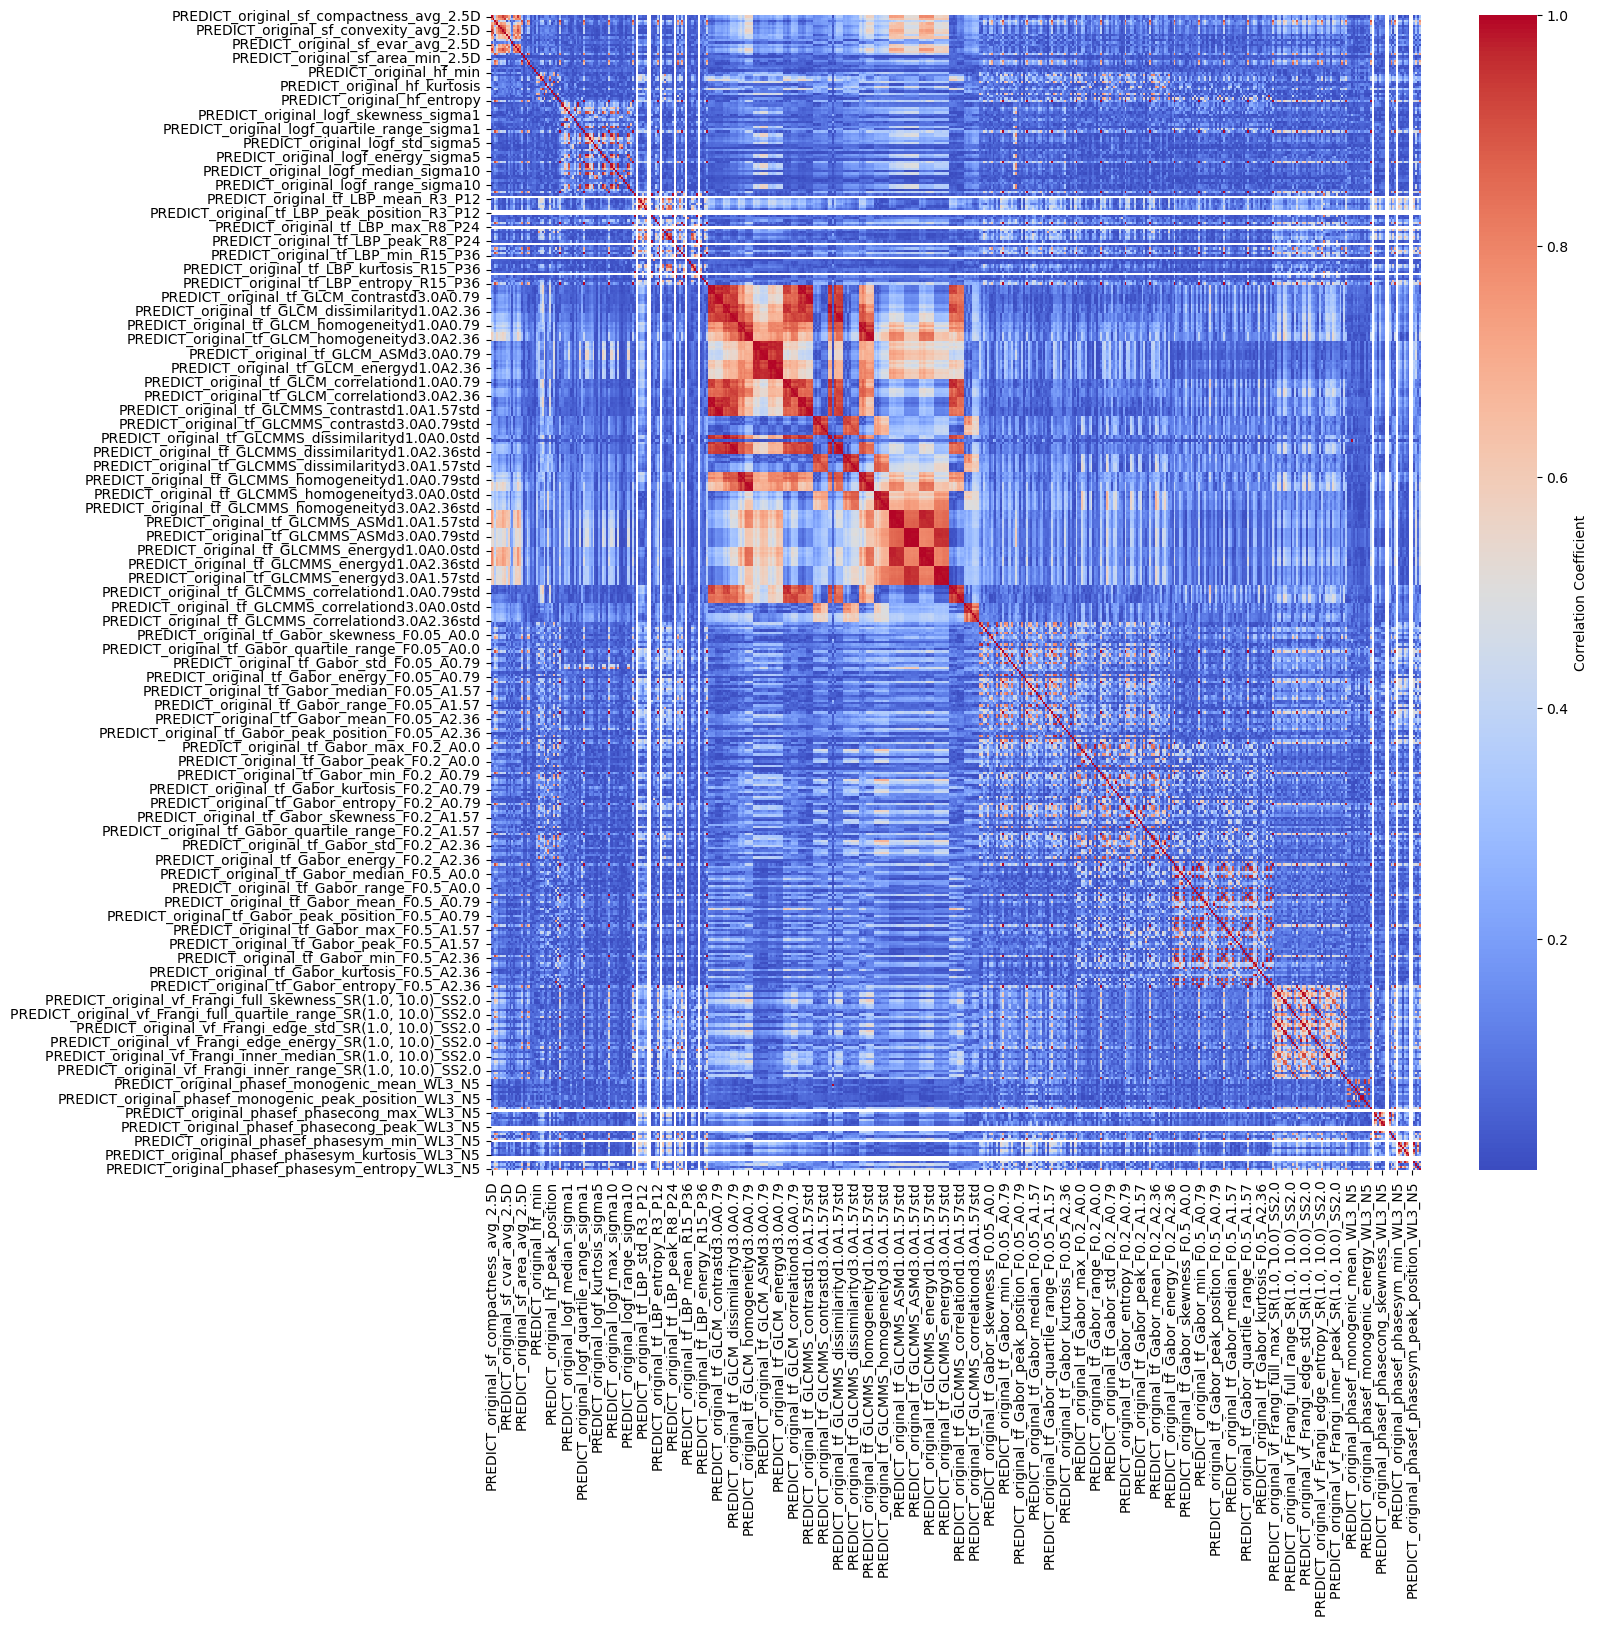

In [62]:
from load_data import load_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro

# Code used to load the original data and split into train and test set
# Was only run once at the start to create test and train dataset

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Seperate the labels from the values
labels = data['label']
values = data.drop(columns=['label'])

# Convert 'GIST' and 'non-GIST' to numeric values
labels = labels.map({'GIST': 1, 'non-GIST': 0})

counter = 0
for feature in values.columns:
    stat, p_value = shapiro(values[feature])
    if p_value < 0.05:
        counter += 1
print(f'The number of features that are not normally distributed: {counter}')

# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)
correlation_matrix = values.corr().abs()
plt.figure(figsize=(15, 15))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()

## Hier moeten we nog een code waarin we kijken naar die linearity. 

## Feature selection and dimension reduction

In [63]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from statsmodels import api as sm

def preprocess_train_test(training_values, test_values):
    # First we remove NaNs by averaging
    training_values = training_values.fillna(training_values.mean())
    test_values = test_values.fillna(training_values.mean())

   # Remove features with zero variance
   # Initialize the VarianceThreshold selector
    selector = VarianceThreshold(threshold=0) 

    # Fit the selector on the training data
    training_non_zero_var = selector.fit_transform(training_values)
    training_values = pd.DataFrame(training_non_zero_var, columns=training_values.columns[selector.get_support()], index=training_values.index)

    # Apply the same transformation to the test data
    test_non_zero_var = selector.transform(test_values)
    test_values = pd.DataFrame(test_non_zero_var, columns=test_values.columns[selector.get_support()], index=test_values.index)

    # Standardize the training & testing data separately
    scaler = StandardScaler()
    scaled_training_values = scaler.fit_transform(training_non_zero_var)

    training_values = pd.DataFrame(scaled_training_values, columns=training_values.columns, index=training_values.index)

    scaled_test_values = scaler.transform(test_non_zero_var)
    test_values = pd.DataFrame(scaled_test_values, columns=test_values.columns, index=test_values.index)

    return training_values, test_values

def statistical_selection(values, labels):
    # Now we can run the logistic regression model for each feature to get its correlation with the label
    p_values = {}

    for column in values.columns:
        logit_model = sm.Logit(labels, values[column])
        result = logit_model.fit(disp = False)

        p_values[column] = result.pvalues[column]

    # Now we remove highly correlated features
    # Make a correlation matrix to analyse the correlation between the features
    correlation_matrix = values.corr().abs()

    features_to_remove = []

    for feature1 in correlation_matrix.columns:
        for feature2 in correlation_matrix.columns:
            if feature1 != feature2 and feature1 not in features_to_remove and feature2 not in features_to_remove:
                if correlation_matrix[feature1][feature2] > 0.90:
                    # Remove the feature with the higher p-value
                    if p_values[feature1] < p_values[feature2]:
                        features_to_remove.append(feature1)
                    else:
                        features_to_remove.append(feature2)

    values = values.drop(columns=features_to_remove)

    return values

## Logistic regression

In [64]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SequentialFeatureSelector

def logistic_regression(training_values, training_labels):
    elastic_net = LogisticRegressionCV(
        solver='saga',
        penalty='elasticnet',
        Cs=[1, 10, 100],
        l1_ratios=[0.8],
        max_iter=5000,
        cv=5,
        n_jobs=-1
    )

    elastic_net.fit(training_values, training_labels)

    #sfs = SequentialFeatureSelector(elastic_net, n_features_to_select=30, direction='forward', n_jobs=-1, scoring = 'accuracy')
    #sfs.fit(training_values, training_labels)

    #selected_indices = sfs.get_support(indices=True)
    #selected_features = training_values.iloc[:, selected_indices]
   
    #cv_scores = cross_val_score(elastic_net, selected_features, training_labels, cv=5, scoring = 'accuracy')
    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=elastic_net,
        X=training_values,
        y=training_labels,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    selected_features = np.where(elastic_net.coef_ != 0)[0]

    print(f"{len(selected_features)} features selected out of {len(training_values.columns)}")

    training_values = training_values.iloc[:, selected_features]

    return elastic_net, cv_scores, training_values



## Random forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def train_random_forest(training_values, training_labels):
    # Initialize the Random Forest Classifier
    param_grid = {
        'n_estimators': randint(1, 100),
        'max_depth': randint(1, 30),
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': randint(1, 10)
        }
    
    random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_

    #sfs = SequentialFeatureSelector(best_model, n_features_to_select=30, direction='forward', n_jobs=-1, scoring = 'accuracy')
    #sfs.fit(training_values, training_labels)

    #selected_indices = sfs.get_support(indices=True)
    #selected_features = training_values.iloc[:, selected_indices]
   
    #cv_scores = cross_val_score(best_model, selected_features, training_labels, cv=5, scoring = 'accuracy')

    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=best_model,
        X=training_values,
        y=training_labels,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    return best_model, cv_scores

    """
    feature_importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': training_values.columns,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    all_scores = []
    for i in range(1, 493):
        top_features = feature_importance_df.head(i)['Feature'].values

        data_selected = training_values[top_features]
        labels_selected = training_labels

        final_model = best_model.fit(data_selected, labels_selected)
        cv_scores = cross_val_score(final_model, data_selected, labels_selected, cv=5)
        all_scores.append(cv_scores.mean())

    # Plot the cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 493), all_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Top Features')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Random Forest Number of Included Top Features')
    plt.grid(True)
    plt.show()
    """

 

## KNN-classifier

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score

def KNN(training_values, training_labels):
    param_grid = {
    'n_neighbors': list(range(1, 26)),
    'weights': ['uniform', 'distance']
    }

    random_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_

    #sfs = SequentialFeatureSelector(best_model, n_features_to_select=30, direction='forward', n_jobs=-1, scoring = 'accuracy')
    #sfs.fit(training_values, training_labels)

    #selected_indices = sfs.get_support(indices=True)
    #selected_features = training_values.iloc[:, selected_indices]
   
    #cv_scores = cross_val_score(best_model, selected_features, training_labels, cv=5, scoring = 'accuracy')
    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=best_model,
        X=training_values,
        y=training_labels,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )


    return best_model, cv_scores


## SVM

In [67]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import cross_validate

def SVM(training_values, training_labels):
    param_grid = {
        'C': [0.1, 0.5, 1, 5, 10, 25], 
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 0.01, 0.1, 1],
        'degree': [2, 3, 4],
    }

    random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,n_iter=100, cv=5, n_jobs=-1)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_
    print(best_model)

    #sfs = SequentialFeatureSelector(best_model, n_features_to_select=30, direction='forward', n_jobs=-1, scoring = 'accuracy')
    #sfs.fit(training_values, training_labels)

    #selected_indices = sfs.get_support(indices=True)
    #selected_features = training_values.iloc[:, selected_indices]
   
    #cv_scores = cross_val_score(best_model, selected_features, training_labels, cv=5, scoring = 'accuracy')

    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=best_model,
        X=training_values,
        y=training_labels,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    return best_model, cv_scores

"""
    train_sizes, train_scores, validation_scores = learning_curve(
        best_model, training_values, training_labels, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation of the scores
    train_mean = train_scores.mean(axis=1)
    validation_mean = validation_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    validation_std = validation_scores.std(axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training score", color="r")
    plt.plot(train_sizes, validation_mean, label="Cross-validation score", color="g")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.2)

    # Adding labels and title
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.ylim(0.3, 1.01)
    plt.title("Learning Curve for SVM")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    return cv_score.mean()

"""

'\n    train_sizes, train_scores, validation_scores = learning_curve(\n        best_model, training_values, training_labels, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)\n    )\n\n    # Calculate the mean and standard deviation of the scores\n    train_mean = train_scores.mean(axis=1)\n    validation_mean = validation_scores.mean(axis=1)\n    train_std = train_scores.std(axis=1)\n    validation_std = validation_scores.std(axis=1)\n\n    # Plot the learning curve\n    plt.figure(figsize=(8, 5))\n    plt.plot(train_sizes, train_mean, label="Training score", color="r")\n    plt.plot(train_sizes, validation_mean, label="Cross-validation score", color="g")\n    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)\n    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.2)\n\n    # Adding labels and title\n    plt.xlabel("Training Size")\n    plt.ylabel("Score")\n    plt.

## Try the different classifiers for 5 different folds

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Create a dataframe to store the results
cross_val_results = []

for fold, (train_index, test_index) in enumerate(skf.split(values, labels)):
    print(f"\n=== Fold {fold} ===")

    training_values = values.iloc[train_index]
    training_labels = labels[train_index]

    test_values = values.iloc[test_index]
    test_labels = labels[test_index]

    training_values, test_values = preprocess_train_test(training_values, test_values)

    training_values = statistical_selection(training_values, training_labels)

    # Now train the classifiers

    logit_model, logit_score, selected_values = logistic_regression(training_values, training_labels)
    print(f"Fold {fold} - Logistic Regression Score: {logit_score}")

    forest_model, forest_score = train_random_forest(training_values, training_labels)
    print(f"Fold {fold} - Random Forest Score: {forest_score}")

    KNN_model, knn_score = KNN(training_values, training_labels)
    print(f"Fold {fold} - KNN Score: {knn_score}")

    SVM_model, svm_score = SVM(training_values, training_labels)
    print(f"Fold {fold} - SVM Score: {svm_score}")

    # Append scores for each model
    cross_val_results.append({'Model': logit_model, 'Fold': fold, 'Precision': logit_score['test_precision'].mean(), 'Recall': logit_score['test_recall'].mean(), 'Accuracy': logit_score['test_accuracy'].mean(), 'ROC AUC': logit_score['test_roc_auc'].mean()})
    cross_val_results.append({'Model': forest_model, 'Fold': fold, 'Precision': forest_score['test_precision'].mean(), 'Recall': forest_score['test_recall'].mean(), 'Accuracy': forest_score['test_accuracy'].mean(), 'ROC AUC': forest_score['test_roc_auc'].mean()})
    cross_val_results.append({'Model': KNN_model, 'Fold': fold, 'Precision': knn_score['test_precision'].mean(), 'Recall': knn_score['test_recall'].mean(), 'Accuracy': knn_score['test_accuracy'].mean(), 'ROC AUC': knn_score['test_roc_auc'].mean()})
    cross_val_results.append({'Model': SVM_model, 'Fold': fold, 'Precision': svm_score['test_precision'].mean(), 'Recall': svm_score['test_recall'].mean(), 'Accuracy': svm_score['test_accuracy'].mean(), 'ROC AUC': svm_score['test_roc_auc'].mean()})

        

# Convert the results list to a dataframe
results_df = pd.DataFrame(cross_val_results)

results_df.to_csv('cross_val_results.csv', index=False)

print(results_df)


=== Fold 0 ===
180 features selected out of 207
Fold 0 - Logistic Regression Score: {'fit_time': array([3.22446561, 3.21745491, 2.5004096 , 2.82670474, 2.53985143]), 'score_time': array([0.00184464, 0.00401902, 0.00878453, 0.00702763, 0.00678658]), 'test_precision': array([0.57142857, 0.52173913, 0.60869565, 0.56      , 0.63157895]), 'test_recall': array([0.6, 0.6, 0.7, 0.7, 0.6]), 'test_accuracy': array([0.575     , 0.51282051, 0.61538462, 0.56410256, 0.61538462]), 'test_roc_auc': array([0.615     , 0.59736842, 0.51315789, 0.60526316, 0.67368421])}
Best hyperparameters: {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 81}
Fold 0 - Random Forest Score: {'fit_time': array([0.11610603, 0.12911415, 0.10998988, 0.11998439, 0.10914874]), 'score_time': array([0.01316047, 0.01381421, 0.02329898, 0.02006555, 0.01661396]), 'test_precision': array([0.84615385, 0.65217391, 0.57894737, 0.54545455, 0.61111111]), 'test_recall': array([0.55, 0.75, 0.55, 0.6 , 0.55]), '